#Importation of libraries

In [8]:
import pandas as pd
import csv
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import csv
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#Graded essays dataset (train and test)

In [13]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')

In [14]:
train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [15]:
test_df.head()

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


#Classic regression models

##CNN

In [16]:
train_df['full_text'] = train_df['full_text'].fillna('').astype(str)
test_df['full_text'] = test_df['full_text'].fillna('').astype(str)
score_columns = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
train_df[score_columns] = train_df[score_columns].apply(pd.to_numeric, errors='coerce')
train_df = train_df.dropna(subset=score_columns)  # Drop any rows with NaN in these columns
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['full_text'])
train_sequences = tokenizer.texts_to_sequences(train_df['full_text'])
train_padded = pad_sequences(train_sequences, maxlen=200, truncating='post', padding='post')
test_sequences = tokenizer.texts_to_sequences(test_df['full_text'])
test_padded = pad_sequences(test_sequences, maxlen=200, truncating='post', padding='post')

# Model: CNN
model = Sequential([
    Embedding(10000, 128, input_length=200),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(6, activation='linear')
])
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# Prepare labels
y_train = train_df[score_columns].values

# Train the model
model.fit(train_padded, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Make predictions
predictions = model.predict(test_padded)

history = model.fit(train_padded, y_train, epochs=10, batch_size=32, validation_split=0.2)
final_val_mse = history.history['val_mse'][-1]
final_val_rmse = np.sqrt(final_val_mse)
print("Final Validation MSE:", final_val_mse)
print("Final Validation RMSE:", final_val_rmse)

Epoch 1/10
98/98 [==============================] - 13s 123ms/step - loss: 2.0208 - mse: 2.0208 - val_loss: 0.3915 - val_mse: 0.3915
Epoch 2/10
98/98 [==============================] - 14s 142ms/step - loss: 0.3553 - mse: 0.3553 - val_loss: 0.3649 - val_mse: 0.3649
Epoch 3/10
98/98 [==============================] - 19s 195ms/step - loss: 0.2731 - mse: 0.2731 - val_loss: 0.3305 - val_mse: 0.3305
Epoch 4/10
98/98 [==============================] - 17s 177ms/step - loss: 0.2066 - mse: 0.2066 - val_loss: 0.3164 - val_mse: 0.3164
Epoch 5/10
98/98 [==============================] - 16s 162ms/step - loss: 0.1532 - mse: 0.1532 - val_loss: 0.3090 - val_mse: 0.3090
Epoch 6/10
98/98 [==============================] - 16s 162ms/step - loss: 0.1166 - mse: 0.1166 - val_loss: 0.3079 - val_mse: 0.3079
Epoch 7/10
98/98 [==============================] - 15s 156ms/step - loss: 0.0913 - mse: 0.0913 - val_loss: 0.3073 - val_mse: 0.3073
Epoch 8/10
98/98 [==============================] - 15s 152ms/step - 

##Ridge regressor

In [17]:
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(train_df['full_text']).toarray()
y = train_df[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
ridge_mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {ridge_mse}")
ridge_rmse = np.sqrt(ridge_mse)
print(f"RMSE: {ridge_rmse}")

Mean Squared Error: 0.30985162942914546
RMSE: 0.5566431796304931


##Lasso

In [18]:
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f"Lasso Regression Mean Squared Error: {mse_lasso}")
rmse_lasso = np.sqrt(mse_lasso)
print(f"Lasso Regression RMSE: {rmse_lasso}")

Lasso Regression Mean Squared Error: 0.4264373190736956
Lasso Regression RMSE: 0.653021683463647


##SVR

In [19]:
svr_model = MultiOutputRegressor(SVR(kernel='linear'))
svr_model.fit(X_train, y_train)
y_pred_svr = svr_model.predict(X_test)
mse_svr = mean_squared_error(y_test, y_pred_svr)
print(f"Support Vector Regression Mean Squared Error: {mse_svr}")
rmse_svr = np.sqrt(mse_svr)
print(f"Support Vector Regression RMSE: {rmse_svr}")

Support Vector Regression Mean Squared Error: 0.33156539748009733
Support Vector Regression RMSE: 0.575817156291906


##Random Forest

In [20]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest Regressor Mean Squared Error: {mse_rf}")
rmse_rf = np.sqrt(mse_rf)
print(f"Random Forest Regressor RMSE: {rmse_rf}")

Random Forest Regressor Mean Squared Error: 0.32691933269476353
Random Forest Regressor RMSE: 0.5717686006548135


#Results and comparison

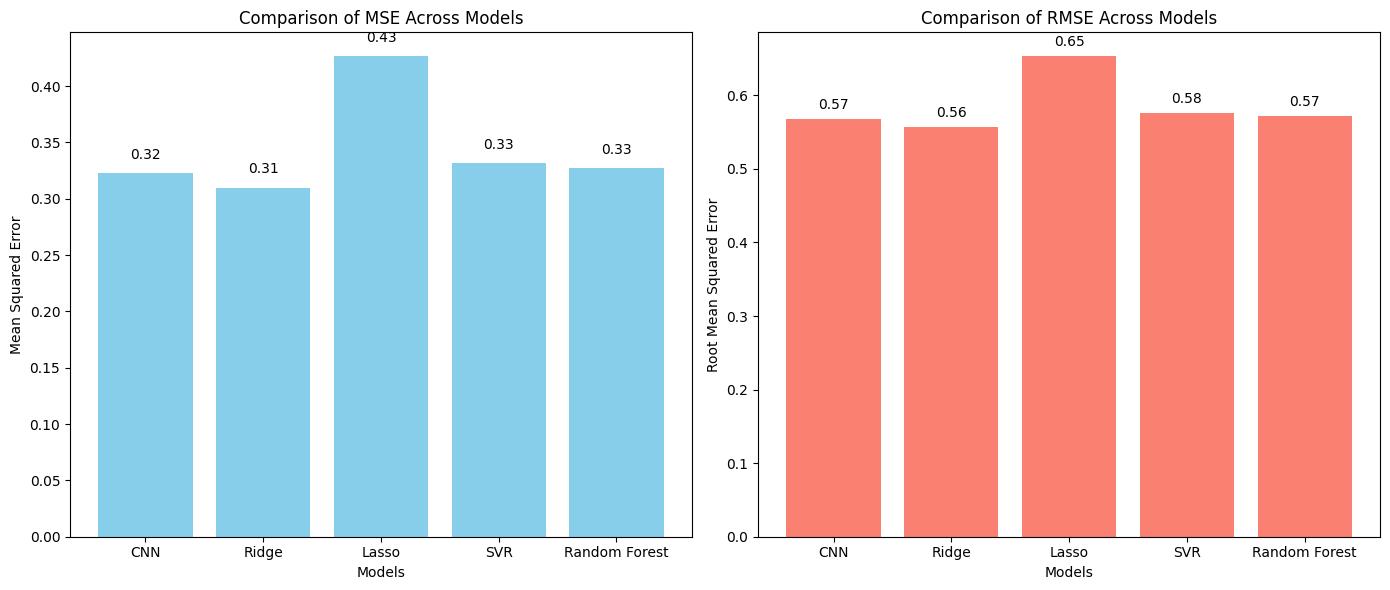

In [22]:
model_names = ['CNN', 'Ridge', 'Lasso', 'SVR', 'Random Forest']
mse_values = [final_val_mse, ridge_mse, mse_lasso, mse_svr, mse_rf]
rmse_values = [final_val_rmse, ridge_rmse, rmse_lasso, rmse_svr, rmse_rf]

# Plot
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.bar(model_names, mse_values, color='skyblue')
plt.title('Comparison of MSE Across Models')
plt.ylabel('Mean Squared Error')
plt.xlabel('Models')
for i, v in enumerate(mse_values):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')
plt.subplot(1, 2, 2)
plt.bar(model_names, rmse_values, color='salmon')
plt.title('Comparison of RMSE Across Models')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Models')
for i, v in enumerate(rmse_values):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()